# Lecture 4: Variance Reduction

AM207: Pavlos Protopapas, Harvard University

Feb 5, 2014

------


We will discuss methods that may be used to reduce  the standard error of 
the sample mean approximation (or the integral). 
We will look into four different methods and we compare them
to mean Monte Carlo methods with examples. 

$$
\newcommand{\var}{{\rm var}}
\newcommand{\cov}{{\rm cov}}
\newcommand{\corr}{{\rm corr}}
$$

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## 1. Control Variates

The basic idea is to transform the function we would like to integrate into 
a different function where the variance of this new functions is much smaller
(or flatter).

Suppose again that we wish to estimate  $E[Y]$, where $Y = f(X)$ is the output of a simulation experiment.
Suppose the mean of a function $Z=g(X)$, $E[Z]=\tau$ is known or easily
estimated with a simulation. The transformation $f(X) \rightarrow f^{\star}(X) = f(X) - g(X)$ will
 yield the same value, $E[ f^{\star}] = E[f]$. 
 
 The control variate method finds the best way to do so for 
 any arbitrary function $g(X)$. To do so we introduce a new function $f^{\star}$:
 
$$ f^{\star} (X) = f(X) + b[g(X)-\tau] $$

where $b$ is a constant. 

The expectation of this new function is identical to the original function, 

$$ E[ f^{\star}] =  E[ f] + b \, E[ g] - b \, \tau=  E[ f].  $$


Also the variance of the new function is 

\begin{equation}
 \var(f^{\star}) = \var(f)+b^2 \,\var( g) +2 \,b\, \cov(f,g)  
 \end{equation}


Since we are free to choose $b$, we should choose it to minimize $\var(f^{\star}) $. Simple calculus then implies that the
optimal value of $b$ is given by

$$ b_c = -\frac{\cov(f,g)}{\var(g)} $$

Substituting for $b_c$ above we see that

$$ \var(f^{\star}) = \var(f) - \frac{[\cov(f,g)]^2}{\var(g)}  = \var(f) (1-\rho^2(f,g)) $$

where $\rho(f,g)$ is the correlation coefficient of $f$ and $g$. 
This means that if $\rho^2$ is close to one, the variance of $f^{\star}$ becomes close
to zero. 
The function $g$ is called the control variate for $f$.

Now back to our integral. To use the control variate $g$ in our simulation we would like to modify our
algorithm so that after generating n samples of $f(X)$ and $g(X)$ we would simply set

 $$ I = \int_{V} f(x) dx \approx \frac{V}{N} \sum_i f^{\star}(x_i) =  \frac{V}{N} \sum_i \left[ f(x_i) +b_c (g(x_i) -\tau) \right] $$
 
 There is of course a problem with this.  We usually do not know $\cov(f,g)$. We overcome this problem by
approximating it from the samples. 

###Example

In this example we would like to estimate the integral of the function $f(x) = \cos(x) \exp(-x)+0.2  $ from 0 to 10. 

$$ I = \int_{0}^{10} dx [\cos(x) \exp(-x)+0.2] $$

and we introduce a control variate $g(x) =exp(-x)+0.2 $. This function is chosen such 
as the correlation of $f,g$ is close to one. [HOW DO I KNOW THIS?]

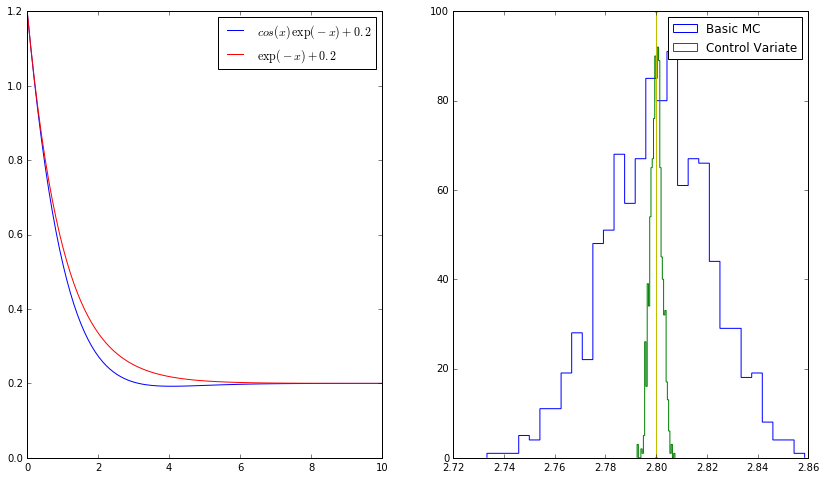

In [2]:
plt.figure(figsize=[14,8])

xmax = 10
xmin = 0
N=10000

w = 0.5

# ==================================
# derivative of the function
# =================================
f = lambda x: np.cos(w*x)*np.exp(-x)+0.2;
g = lambda x: np.exp(-x)+0.2;
fint= lambda z: z/5.0- (4.0*np.cos(z/2.0))/(5.0*np.exp(z)) + (2.0*np.sin(z/2.0))/(5.0*np.exp(z))
fint_vr = lambda z: z/5  -1/np.exp(z)  

# ============================
# plot it
# ============================
x = np.linspace(0,10, 100)

plt.subplot(1,2,1)
plt.plot(x, f(x), 'b', label=u'$cos(x)\, \exp(-x)+0.2$') 
plt.plot( x, g(x), 'r', label = u'$\exp(-x)+0.2$')
plt.legend()

Ivmc = np.zeros(1000)
Imc_vr = np.zeros(1000)


#exact value 
true_val = fint(xmax) - fint(xmin)

tau =(1.0/(xmax-xmin))*(fint_vr(xmax)-fint_vr(xmin));

# DO THIS FEW TIMES
for k in np.arange(0,1000):

    # ----------------------
    # lets do the normal MC
    # ----------------------

   
    X = np.random.uniform( low=xmin, high=xmax, size=N)
    Ivmc[k] = (xmax-xmin)*np.mean(f(X));

    # ----------------------
    # CONTROL VARIATE
    # ----------------------
    
    q = np.cov(g(X),f(X));
    
    b =- q[0,1]/np.var(g(X));
       
 
    
    
    Imc_vr[k] = (xmax-xmin)*(np.mean(f(X)) + b *(np.mean(g(X)) -tau));




yreal = true_val*np.ones(30);

plt.subplot(1,2,2)
plt.hist(Ivmc,30, histtype='step', label=u'Basic MC');
# bar(b1,h1, 1, 'FaceColor', 'none', 'EdgeColor', 'red')
plt.hist(Imc_vr,30, histtype='step', label = u'Control Variate');
# bar(b2,h2, 1, 'FaceColor', 'none', 'EdgeColor', 'blue')
plt.plot([true_val, true_val], [0 ,100], 'y.-') 
plt.legend()
#legend('VMC', 'VR', 'True Value')


### 1.1 Multiple Control Variates

Up until now we have only considered the possibility of using one control variate. However, there is no reason
why we should not use more than one and I will now describe how to do this. 
Suppose again that we wish to estimate    $E[Y]$ where $Y = f(X)$ is the output of a simulation experiment.
We also suppose that the means of the functions $E[Z_i]=\tau_i$ where $Z_i=g_i(X)$ for $i= 1\ldots m$ 
is known for each $i$.

We can then construct unbiased estimators of $E[Y]$ by setting 

$$  f^{\star}(X) = f(X)+b_1 \left[ g_1(X) - \tau_1\right] +b_2 \left[ g_2(X) - \tau_2\right] +\ldots +b_m \left[ g_m(X) - \tau_m\right] $$

To choose a good set of $b_i$'s, we compute $\var(f^{\star})$ and obtain

$$ \var(f^{\star}) = \var(f) +2 \, \sum_i^{m} b_i\, \cov(f,g_i) + \sum_{i}^{m} \sum_{j}^{m} b_i \, b_j \cov(g_i, g_j) $$

As before, we could use use calculus to find the optimal set of $b_i$'s 
by taking partial derivatives with respect to each $b_i$, 
set them equal to 0 and solve the resulting system of $m$ linear equations and $m$ unknowns. 
This is easy to do but as before, however, the optimal solutions $b_{i,c}$'s
will involve unknown quantities so that they will need to be
estimated using the samples. A convenient way of estimating the $b_{i,c}$'s
is to observe that $b_{i,c}=c_i$'s, where $c_i$'s are the solution to the linear regression 

$$ Y = a + c_1 g_1(X) + \ldots + c_m g_m(X) + \epsilon $$

where  $\epsilon $ is an error term. 
[PROVE THIS]

## 2. Antithetic Variates

Suppose as usual that we would like to estimate $E[f(X)] = E[Y ]$, 
and that we have generated two samples,
$Y_1=f(X_1)$ and $Y_2=f(X_2)$. Then the expectation of

$$ Z = \frac{1}{2} \left[  Y_1 + Y_2 \right] $$

$E[Z] = E[Y]$

and 

$$ \var(Z) = \frac{ \var(Y_1)+\var(Y_2) + 2 \cov(Y_1,Y_2)}{4}. $$

Therefore, the more negatively correlated $Y_1=f(X_1)$ is with $Y_2=f(X_2)$, the more the variance will be reduced.
If $Y_1$ and $Y_2$ are iid, then the $\var(Z) = \var(Y_1)/2=\var(Y_2)/2$.
On the other hand, we could reduce $\var(Z)$ if we could make it so that
$\cov(Y_1, Y_2) < 0$. 

Lets try it out. Generate two samples that are correlated 

In [3]:
Y1= np.random.uniform(low=0, high=1, size=10000)
Y2a= np.random.uniform(low=0, high=1, size=10000)

rho =-0.9

Y2 = rho + np.sqrt(1-rho**2) * Y2a

Z= 0.5*(Y1+Y2)
print np.var(Z), np.var(Y1), np.var(Y2), np.cov(Y1,Y2)


0.0249911686342 0.0830685987191 0.0160772422815 [[ 0.08307691  0.00040946]
 [ 0.00040946  0.01607885]]


The method of antithetic variates describes how to do this idea in reducing the estimator error of an integral. 
Suppose $X \sim U(0, 1)$ iid random variables and

$$ \theta=E[f(X)]=E[f(U)] $$

If we construct two samples $U$ and $1-U$, each of length $n$ and now define
$$ Y_1 = f(U)  \hspace{2cm} Y_2 = f(1-U) $$

then the expectation of 
$$Z = \frac{1}{2} \left[  Y_1 + Y_2 \right] $$
$E[Z] = E[Y]$ as before. 

If we to compare this with the mean MC with  $2n$ sample, the question
remains as to which algorithm is better. 
Note that both algorithms require approximately the same amount of time. 
That is, comparing the two algorithms amounts to computing which estimator has a smaller variance.

Say we want to calculate 

$$ I = \int f(X) dX $$

and let $X\sim U(0,1)$ for $2n$ samples and $Y=f(X)$, 

$$ \var(\hat{I}_{2n}) = \frac{\var(Y)}{2n} $$ 

on the other hand 

$$ \var(\hat{I}_{n+n})  = \frac{\var(Z)}{n}  = \frac{\var(Y_1+Y_2)}{4n} = \frac{\var(Y_1)}{2n}+\frac{\cov(Y_1,Y_2)}{2n} $$

So again to reduce the $\hat{I}_{n+n}$, we would like to make the $\cov(Y_1,Y_2)$ as negative 
as possible. 

If the $Y$'s are monotonic functions of $X$ then this guarantees if $Y_1 = f(X)$ and $Y_2=f(1-X)$ then
$Y_1,Y_2$  are negatively correlated.

### Example

In this example we are trying to calculate  the integral of $f(x) = 1/(x+1)$ from $[0,1]$. To do so 
 we generate $X_1=U$ from a uniform distribution and $X_2=1-U$. Because $X_1,X_2$ are correlated,
 one can show that $Y_1=f(X_1),Y_2=f(X_2)$ are also strongly correlated if the function is monotonic.
 [PROOF]
 

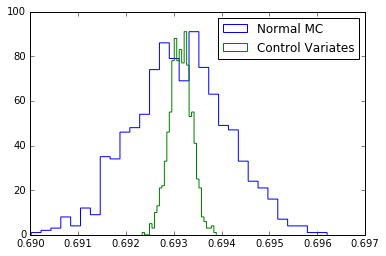

In [4]:
N =10000
xmin = 0 
xmax = 1


# ==============================
# DEFINE FUNTION 
# ==============================
Y = lambda x:  1/(x+1)
intY = lambda x: np.log(x+1) 

Iact = intY(xmax)-intY(xmin)

Ivmc=np.zeros(1000)
Iant=np.zeros(1000)
# ==============================
# GENERATING THE SAMPLE X1, X2 iid 
# and X1 amd Y1 negatively correlated 
# ==============================
for k in np.arange(0,1000):
    U = np.random.uniform(low=0, high=1, size=2*N)
    X=U



    # ==============================
    # VANILLA MC
    # ==============================
    Ivmc[k] =  np.mean(Y(X))

    # ==============================
    # ANTITHETIC MC
    # ==============================
    U = np.random.uniform(low=0, high=1, size=N) 
    X1= U
    X2= 1-U
    Iant[k] = 0.5*( np.mean(Y(X1))+np.mean(Y(X2)))


plt.hist(Ivmc,30, histtype='step', label=u'Normal MC')
plt.hist(Iant,30,  histtype='step', label=u'Control Variates')
plt.legend()

## 3. Stratified Method

The key idea is to achieve a more regular sampling of the
most `important' dimension in the uncertainty.
Start by considering a one-dimensional problem:

$$ I= \int_{0}^{1} f(x) \, dx $$

and lets assume $x$ is drawn from a uniform distribution. 

$$ I= \int_{0}^{1} f(U) \, dU $$

Instead of taking $N$ samples, drawn from uniform
distribution, we break the interval into $M$ _strata_ of equal width and take $L$ samples for each
strate, $N=LM$.

Let $U_{ij}$ be the value of the $i$-th sample and strata $j$. The average from strata $j$ is

\begin{equation} 
I_j = E[f(U_j)]\approx  \frac{1}{L} \sum_i f(U_{ij}) 
\end{equation}

and the overall integral without stratification is:

\begin{equation}  
I =E[f(U)] \approx \frac{1}{N}\sum_{i,j}  f(U_{ij}) 
\end{equation}

With stratification we would average the estimations in each strata
\begin{equation}
 I_s \approx \frac{1}{M} \sum_j I_j 
 \end{equation}
and that is obviously the same as the estimation without stratification.
When we take strata we average the estimate for each strata as

\begin{equation} I_s = \frac{1}{M} \sum_j I_j =  \frac{1}{M} \sum_j \frac{1}{L} \sum_{i}  f(U_{ij})=  \frac{1}{N} \sum_{i,j}  f(U_{ij})= I
\end{equation}

To do the analysis of the variance, lets remind ourselves that the 
MC estimated variance is  $\sigma_I=\frac{\var(f)}{N}$. The variance without stratification is then 

\begin{equation} \var(I) = \frac{\var(f)}{N} = \frac{E[f^2] - E[f]^2}{N}  = \frac{E[f^2] - I^2}{N}
\end{equation}

The expectation of $f^2$ can be expanded as 

\begin{equation}
E[f^2] \approx \frac{1}{N} \sum_{ij} f^2(U_{ij}) =\frac{1}{N} \sum_j L \left[ \frac{1}{L} \sum_i f^2(U_{ij}) \right]=\frac{L}{N}  \sum_j E[f^2(U_j)] = \frac{1}{M}  \sum_j E[f^2(U_j)] 
\end{equation}

however from the definition of $\sigma_j^2$ 

\begin{eqnarray} 
\sigma_j^2 = E[ f^2(U_j)] - E[f(U_j)]^2 &=& E[ f^2(U_j)] - I_j^2  \nonumber \\
 &\Rightarrow& E[ f^2(U_j)] =\sigma_j^2 + I_j^2   
\end{eqnarray}

substituting this, we get

\begin{equation}
\var(I) =\frac{ \frac{1}{M}  \sum_j  (\sigma_j^2 + I_j^2)- I^2}{N} = \frac{1}{NM}\sum_j  \sigma_j^2 + \frac{1}{N} \left( \frac{\sum_j  I_j^2}{M} -  I^2 \right)
\end{equation}

the variance with stratification is 

\begin{equation}  \var(I_s)= \var\left(  \frac{1}{M} \sum_j I_j  \right)  = \frac{1}{M^2}  \var\left(\sum_j I_j  \right)  = \frac{1}{M^2}  \sum_j \var(I_j)
 = \frac{1}{M^2}   \sum_j  \frac{\sigma_j^2}{L} =  \frac{1}{M^2 \,L}   \sum_j  \sigma_j^2\end{equation}
 
where we ignore all covariances since the deviations about $I_j$ are all iid and uncorrelated. Finally, 

\begin{equation}
  \var(I_s)= \frac{1}{M^2} \frac{ 1}{L}   \sum_j \sigma_j^2  =  \frac{1}{MN}  \sum_j \sigma_j^2 \le \var(I)
\end{equation}

where the last step is based on the fact that 
$$  \frac{\sum_j  I_j^2}{M} -  I^2  > 0 $$
by the Cauchy-Schwarz Inequality.

Thus stratified sampling reduces the variance.


Sub-dividing into strata always reduces the variance, so the optimum choice is to use 1 sample per
stratum. 
However, we need multiple samples in each stratum to
estimate the variance and obtain a confidence interval.
Despite this, interesting to analyze what happens with
1 sample per stratum.

###Example

For a  one-dimensional application we take $ x/(x^2+1)$ and integrate from $[0,1]$.
We break $[0,10]$ into $M$ strata and for each stratum, take $N/M$ samples
with uniform probability distribution. Compute the average within each 
stratum, and then calculate the overall average. 

C:\Users\vkaynig\Anaconda2\lib\site-packages\ipykernel\__main__.py:37: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


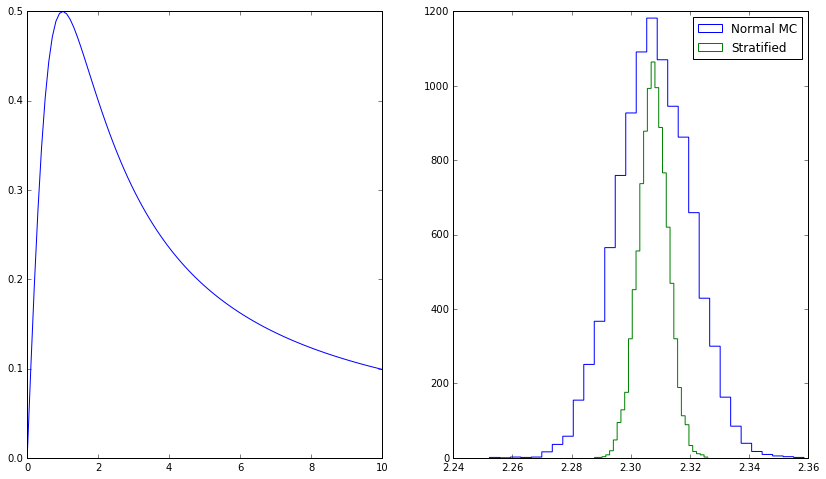

In [5]:
plt.figure(figsize=[14,8])
Y = lambda x: x/(x**2+1.0);
intY = lambda x: np.log(x**2 + 1.0)/2.0;

## Ploting the original functions 
plt.subplot(1,2,1)
x = np.linspace(0,10,100)
plt.plot(x, Y(x), label=u'$x/(x**2+1)$')

N= 10000
M = 10   # number of strate 

xmin=0
xmax =10

# analytic solution 
Ic = intY(xmax)-intY(xmin)

Imc = np.zeros(N)
Is = np.zeros(N)
for k in np.arange(0,N):
 
    Umin=0
    Umax =10
    # First lets do it with mean MC method 
    U = np.random.uniform(low=Umin, high=Umax, size=N)
    Imc[k] = (Umax-Umin)* np.mean(Y(U))

    #stratisfied it in Ns regions
    step = (Umax-Umin )/M
    Umin = 0 
    Umax = step
    Ii = 0
    
    
    for reg in np.arange(0,M):
        x = np.random.uniform(low=Umin, high=Umax, size=1.0*N/M);
        Ii = Ii+(Umax-Umin)* np.mean(Y(x))
        Umin = Umin + step
        Umax = Umin + step


    Is[k] = Ii

plt.subplot(1,2,2)
plt.hist(Imc,30, histtype='step', label=u'Normal MC')
plt.hist(Is, 30, histtype='step', label=u'Stratified')
plt.legend()

